* Electricity price forecasting with DNNs (+ EDA)


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
import warnings
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# **Exploration and Cleaning**

In [2]:
url='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/main/Forecasting/Demanda%20de%20electricidad/electricity_prices.csv'
df_elec=pd.read_csv(url,sep=',')
df_elec.head()

<ipython-input-2-9f08303e47cc>:2: DtypeWarning: Columns (9,10,11,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_elec=pd.read_csv(url,sep=',')


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [3]:
df_elec.shape

(38014, 18)

In [4]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                38014 non-null  object
 1   Holiday                 38014 non-null  object
 2   HolidayFlag             38014 non-null  int64 
 3   DayOfWeek               38014 non-null  int64 
 4   WeekOfYear              38014 non-null  int64 
 5   Day                     38014 non-null  int64 
 6   Month                   38014 non-null  int64 
 7   Year                    38014 non-null  int64 
 8   PeriodOfDay             38014 non-null  int64 
 9   ForecastWindProduction  38014 non-null  object
 10  SystemLoadEA            38014 non-null  object
 11  SMPEA                   38014 non-null  object
 12  ORKTemperature          38014 non-null  object
 13  ORKWindspeed            38014 non-null  object
 14  CO2Intensity            38014 non-null  object
 15  Ac

In [5]:
df_elec.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [6]:
columns_to_convert=['ForecastWindProduction',
       'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed',
       'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']

df_elec[columns_to_convert].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ForecastWindProduction  38014 non-null  object
 1   SystemLoadEA            38014 non-null  object
 2   SMPEA                   38014 non-null  object
 3   ORKTemperature          38014 non-null  object
 4   ORKWindspeed            38014 non-null  object
 5   CO2Intensity            38014 non-null  object
 6   ActualWindProduction    38014 non-null  object
 7   SystemLoadEP2           38014 non-null  object
 8   SMPEP2                  38014 non-null  object
dtypes: object(9)
memory usage: 2.6+ MB


In [7]:
# Itera a través de las columnas y convierte su contenido a tipo entero
for column in columns_to_convert:
    df_elec[column] = pd.to_numeric(df_elec[column], errors='coerce', downcast='integer')

# La opción 'errors' como 'coerce' convierte los valores no numéricos a NaN

# Verifica el resultado
print(df_elec.dtypes)

DateTime                   object
Holiday                    object
HolidayFlag                 int64
DayOfWeek                   int64
WeekOfYear                  int64
Day                         int64
Month                       int64
Year                        int64
PeriodOfDay                 int64
ForecastWindProduction    float64
SystemLoadEA              float64
SMPEA                     float64
ORKTemperature            float64
ORKWindspeed              float64
CO2Intensity              float64
ActualWindProduction      float64
SystemLoadEP2             float64
SMPEP2                    float64
dtype: object


In [8]:
df_elec.isnull().sum()

DateTime                    0
Holiday                     0
HolidayFlag                 0
DayOfWeek                   0
WeekOfYear                  0
Day                         0
Month                       0
Year                        0
PeriodOfDay                 0
ForecastWindProduction      5
SystemLoadEA                2
SMPEA                       2
ORKTemperature            295
ORKWindspeed              299
CO2Intensity                7
ActualWindProduction        5
SystemLoadEP2               2
SMPEP2                      2
dtype: int64

In [9]:
df_elec_null=pd.DataFrame(df_elec)
null_rows=df_elec_null[df_elec_null.isnull().any(axis=1)]
null_rows

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
20,01/11/2011 10:00,None,0,1,44,1,11,2011,20,513.17,4793.60,61.46,NaN,NaN,535.37,324.0,4460.41,58.33
67,02/11/2011 09:30,None,0,2,44,2,11,2011,19,1280.20,4820.55,55.57,NaN,NaN,463.72,1294.0,4213.87,53.28
69,02/11/2011 10:30,None,0,2,44,2,11,2011,21,1278.20,4885.14,55.57,NaN,NaN,466.15,1317.0,4323.18,54.36
697,15/11/2011 12:30,None,0,1,46,15,11,2011,25,571.54,5016.11,53.82,NaN,NaN,494.76,748.0,4639.29,65.36
797,17/11/2011 14:30,None,0,3,46,17,11,2011,29,1459.65,4894.54,55.64,NaN,NaN,417.05,1389.0,4445.39,45.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37725,25/12/2013 23:30,Christmas,1,2,52,25,12,2013,47,384.17,3628.31,43.00,NaN,NaN,385.70,423.0,3427.76,54.23
37727,26/12/2013 00:30,St Stephen's Day,1,3,52,26,12,2013,1,438.89,3314.01,34.39,NaN,NaN,467.16,426.0,3135.54,37.81
37729,26/12/2013 01:30,St Stephen's Day,1,3,52,26,12,2013,3,475.03,3048.80,31.59,NaN,NaN,491.63,499.0,2851.88,37.81
37821,27/12/2013 23:30,None,0,4,52,27,12,2013,47,944.12,3829.10,64.71,NaN,NaN,271.62,671.0,3504.47,71.88


In [10]:
df_elec.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.0,11.1,571.52,346.0,2655.64,39.87


In [11]:
df_elec['DateTime']=pd.to_datetime(df_elec['DateTime'],format='%d/%m/%Y %H:%M')
dates = df_elec['DateTime'].apply(lambda x: x.date()).unique()

In [12]:
time_features = [
    'PeriodOfDay',
    'DayOfWeek',
    'WeekOfYear',
    'Day',
    'Month',
    'Year'
]

metadata_features = [
    'SMPEP2',
    'ForecastWindProduction',
    'SystemLoadEA',
    'SMPEA',
    'ORKTemperature',
    'ORKWindspeed',
    'CO2Intensity',
    'ActualWindProduction',
    'SystemLoadEP2'
]

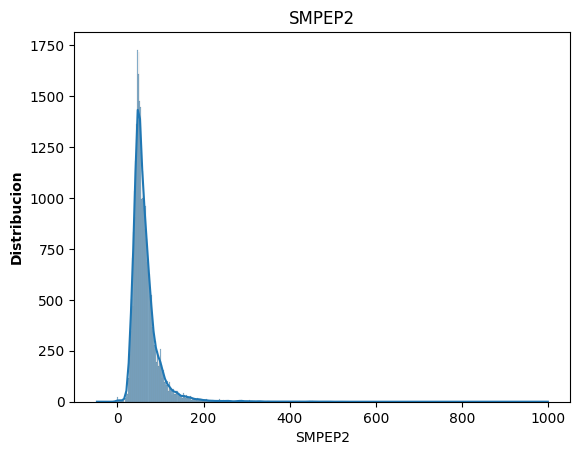

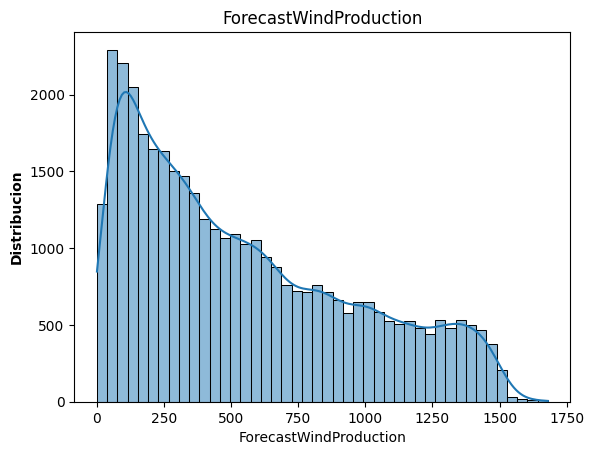

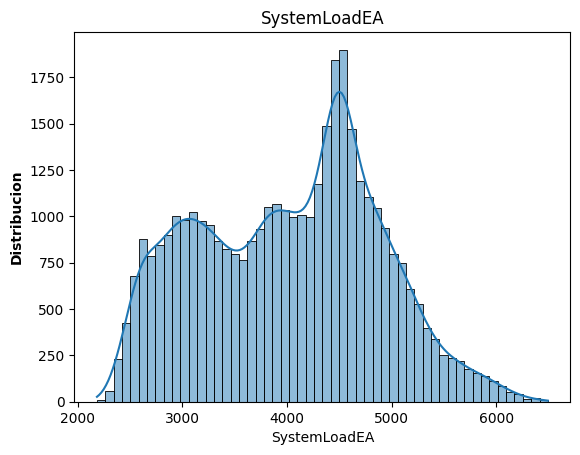

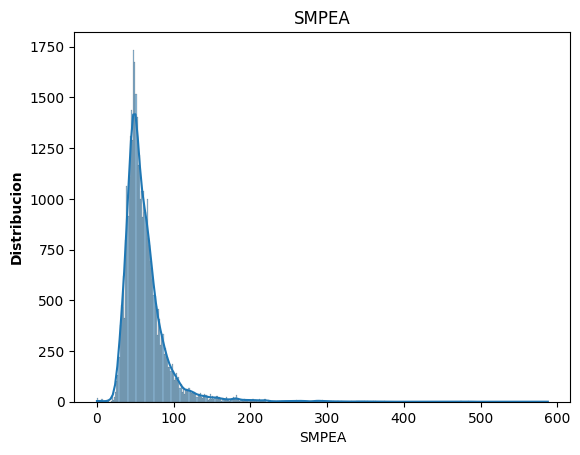

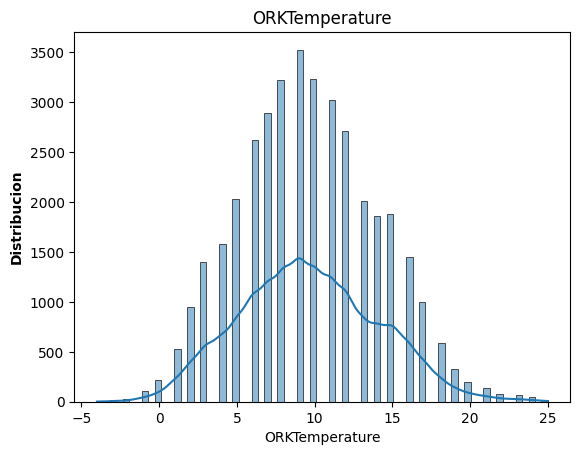

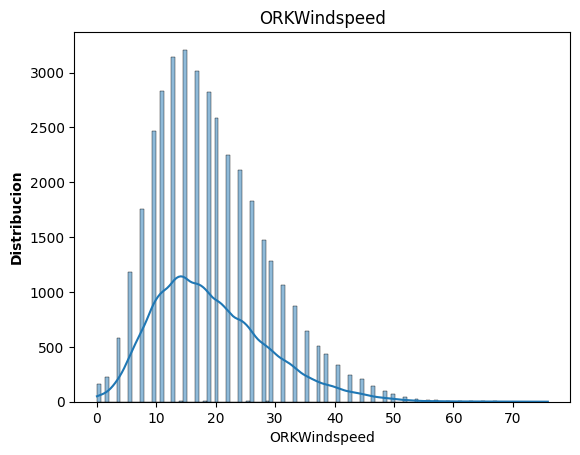

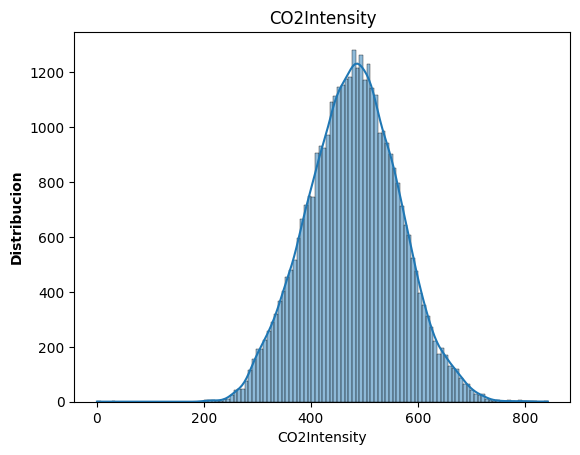

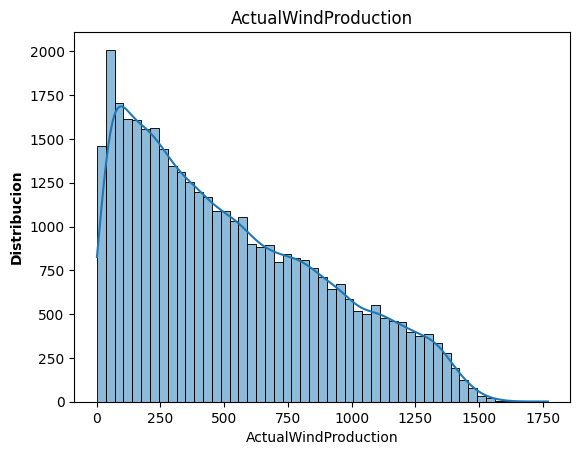

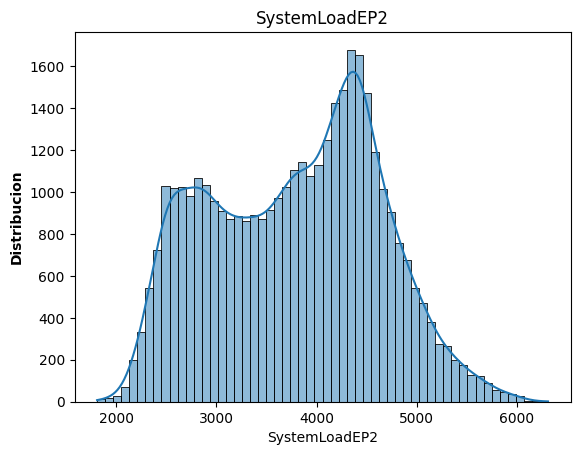

In [13]:
for i in metadata_features:
  sns.histplot(data=df_elec,x=i,kde=True)
  plt.title(i,fontsize=12)
  plt.ylabel('Distribucion',weight='bold')
  plt.show()

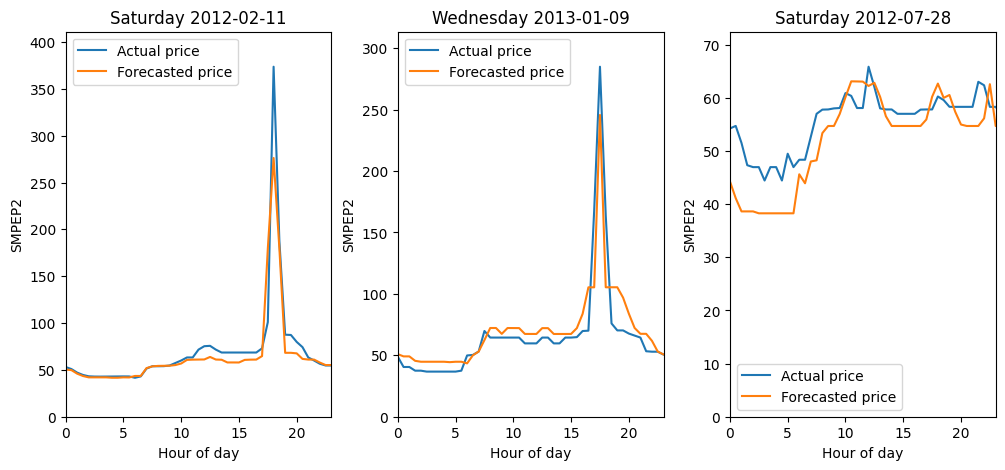

In [14]:
days_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#Plot forecasted and actual price from three random days (default seed = 42)
fig, axes = plt.subplots(1,3, figsize = (12,5))
fig.subplots_adjust(wspace = 0.25)

rs = np.random.seed(42)
for ax in axes:
    rand_date = dates[np.random.randint(0,len(dates))]
    price     = df_elec['SMPEP2'][df_elec['DateTime'].apply(lambda x: x.date()) == rand_date]
    foreprice = df_elec['SMPEA'][df_elec['DateTime'].apply(lambda x: x.date()) == rand_date]

    sns.lineplot(x = np.array(range(0,len(price)))/2, y=price,     ax=ax, label='Actual price')
    sns.lineplot(x = np.array(range(0,len(price)))/2, y=foreprice, ax=ax, label='Forecasted price')

    ax.set_xlabel('Hour of day'); ax.set_ylabel('SMPEP2')
    ax.set(xlim=(0,23), ylim=(0, max(max(price), max(foreprice))*1.10))
    ax.legend()
    ax.title.set_text(days_name[rand_date.weekday()] + ' ' + str(rand_date))


In [15]:
#Compute and report evaluation metrics for forecasted price
mean_target_price = df_elec['SMPEP2'].mean()
RMSE_fore = np.sqrt(1/len(df_elec['SMPEP2'])*np.sum(np.power(df_elec['SMPEP2'] - df_elec['SMPEA'],2)))
MAE_fore = 1/len(df_elec['SMPEP2'])*np.sum(abs(df_elec['SMPEP2'] - df_elec['SMPEA']))
R2_fore = 1 - np.sum(np.power(df_elec['SMPEA'] - df_elec['SMPEP2'], 2))/np.sum(np.power(df_elec['SMPEA'] - mean_target_price, 2))
print(mean_target_price)
print(RMSE_fore)
print(MAE_fore)
print(R2_fore)

64.13682258234243
29.774719407171027
14.948148313779132
0.14931167565723413


<Axes: >

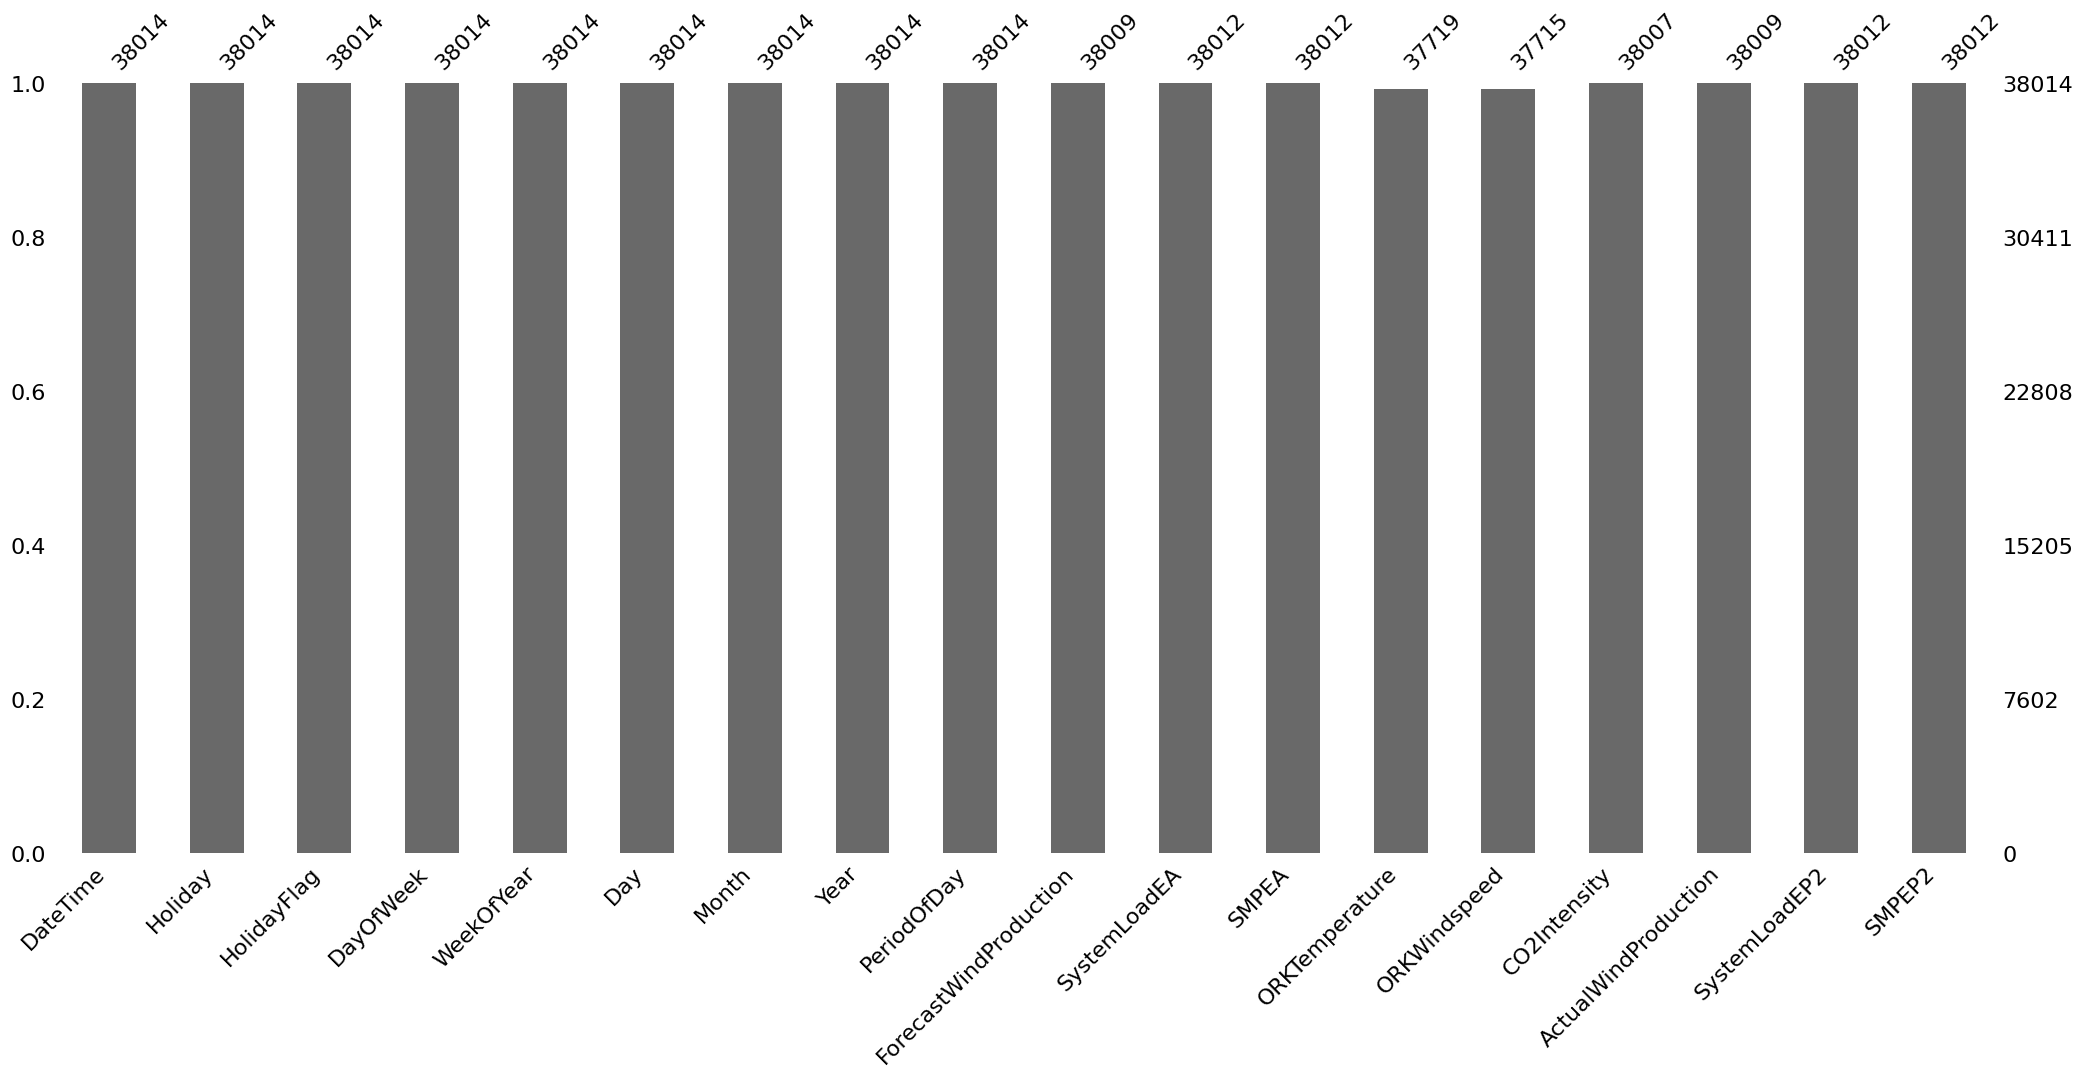

In [16]:
msno.bar(df_elec_null)

<Axes: >

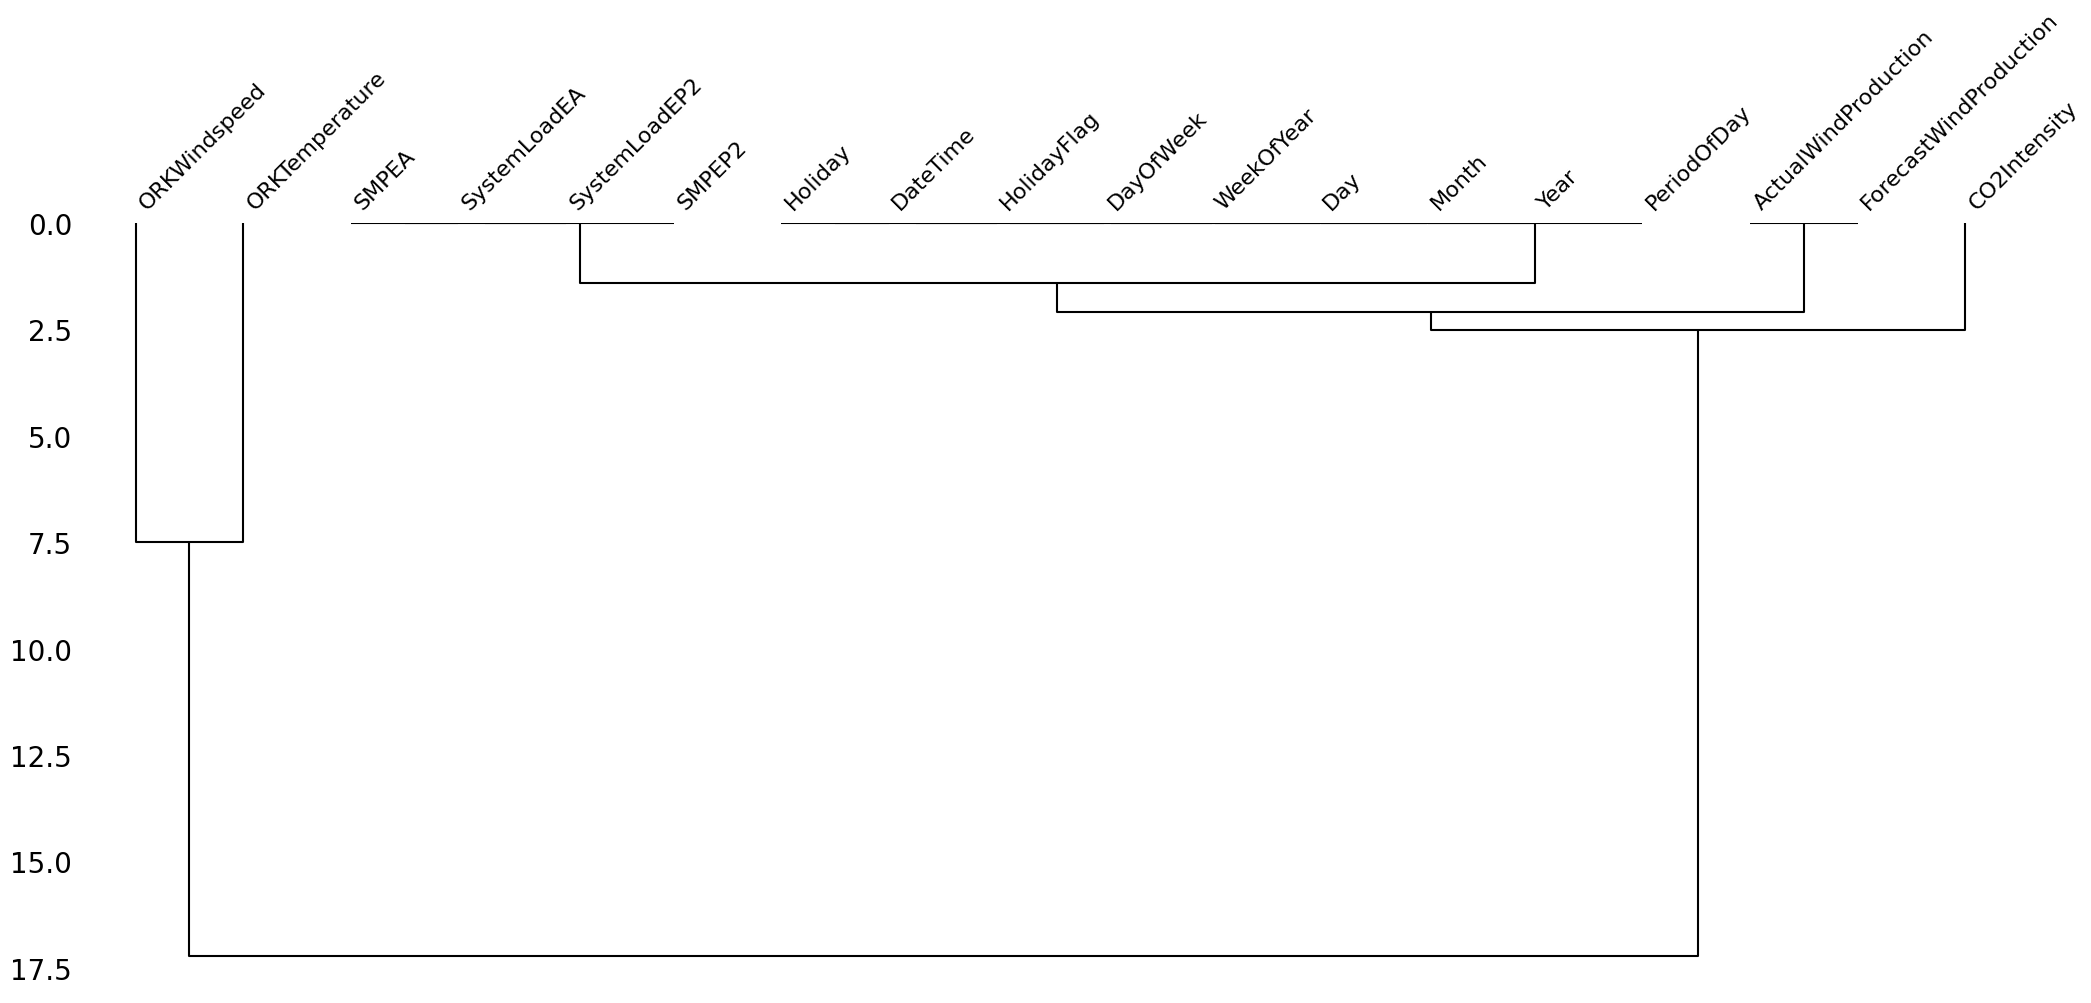

In [17]:
msno.dendrogram(df_elec_null)

In [18]:
df_elec.isnull().sum()

DateTime                    0
Holiday                     0
HolidayFlag                 0
DayOfWeek                   0
WeekOfYear                  0
Day                         0
Month                       0
Year                        0
PeriodOfDay                 0
ForecastWindProduction      5
SystemLoadEA                2
SMPEA                       2
ORKTemperature            295
ORKWindspeed              299
CO2Intensity                7
ActualWindProduction        5
SystemLoadEP2               2
SMPEP2                      2
dtype: int64

In [19]:
df_elec.interpolate(method='pad', limit_direction='forward', inplace=True, axis=0)

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,...,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,monday,midweek,weekend
0,2011-11-01,None,0,1,44,1,11,2011,0,315.31,...,49.26,6.0,9.3,600.71,356.0,3159.6,54.32,0,1,0


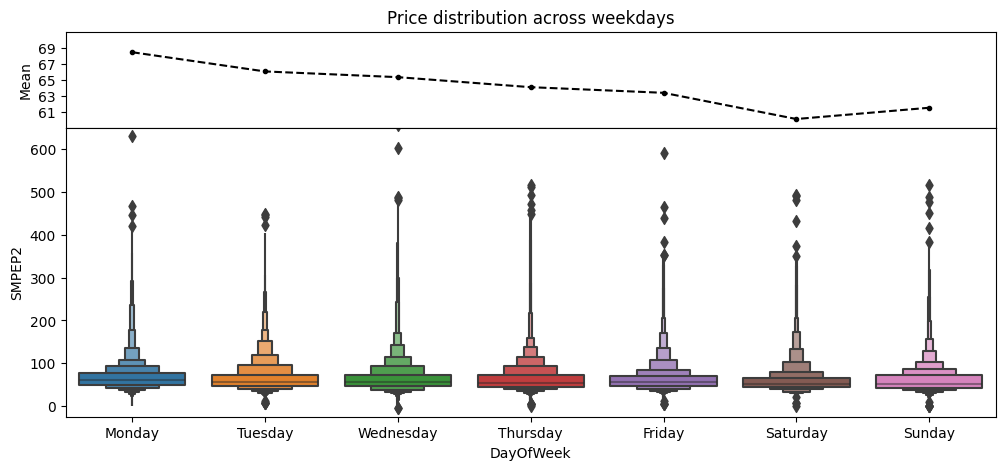

In [20]:
mean_price = []
for day in list(range(0,7)):
    mean_price.append(df_elec['SMPEP2'][df_elec['DayOfWeek'] == day].mean())

#Seaborn boxen plot to visualize the price distribution for each day of the week
fig, axes = plt.subplots(2, 1, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig.subplots_adjust(hspace=0)
axes[0].plot(list(range(0, 7)), mean_price, 'k.--')
sns.boxenplot(data=df_elec, x='DayOfWeek', y='SMPEP2', ax=axes[1])
axes[0].set(ylim=(59, 71), yticks=[61, 63, 65, 67, 69], ylabel='Mean')
axes[0].set_title('Price distribution across weekdays');
axes[1].set(ylim=(-25, 650));
axes[1].set_xticklabels(days_name)



#One-hot encode to three categories for DayOfWeek
day_one_hot = pd.get_dummies(df_elec['DayOfWeek'])

df_elec['monday'] = day_one_hot[0]
df_elec['midweek'] = day_one_hot.iloc[:, 1:4].sum(axis=1)
df_elec['weekend'] = day_one_hot.iloc[:, 4:7].sum(axis=1)

df_elec.head(1)

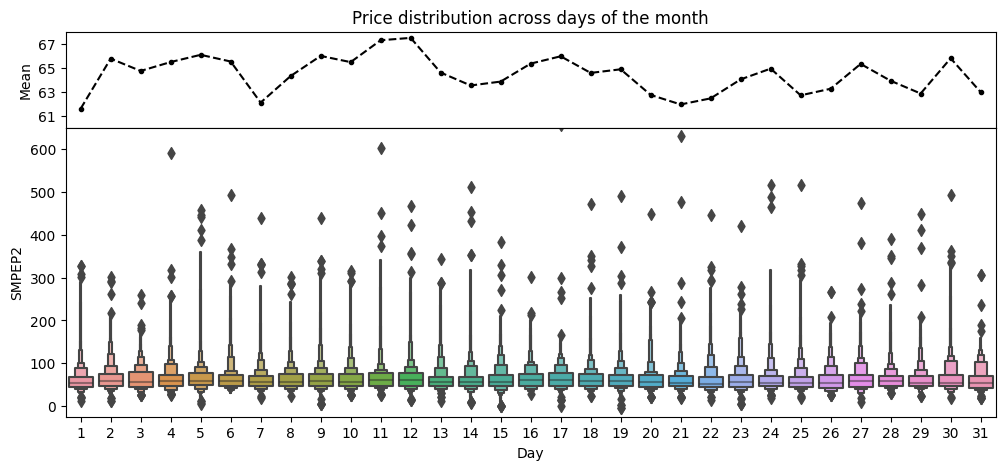

In [21]:
mean_price = []
for day in list(range(1,32)):
    mean_price.append(df_elec['SMPEP2'][(df_elec['Day'] == day) & (df_elec['Year'] != 2011)].mean())

#Seaborn boxen plot to visualize the price distribution for each day of the month
fig, axes = plt.subplots(2, 1, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig.subplots_adjust(hspace=0)
axes[0].plot(list(range(0, 31)), mean_price, 'k.--')
sns.boxenplot(data=df_elec[df_elec['Year'] != 2011], x='Day', y='SMPEP2', ax=axes[1])
axes[0].set(ylim=(60, 68), yticks = [61, 63, 65, 67], ylabel='Mean')
axes[1].set(ylim=(-25, 650));
axes[0].set_title('Price distribution across days of the month')
plt.show()

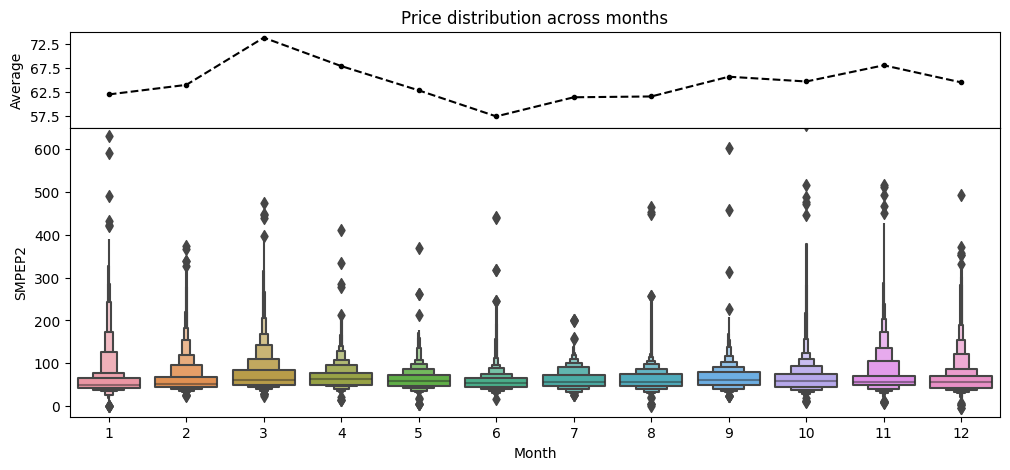

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,...,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,monday,midweek,weekend,winter,summer
0,2011-11-01,None,0,1,44,1,11,2011,0,315.31,...,9.3,600.71,356.0,3159.6,54.32,0,1,0,1,0


In [22]:
#Compute mean prices for each month
mean_price = []
for month in list(range(1, 13)):
    mean_price.append(df_elec['SMPEP2'][(df_elec['Month'] == month) & (df_elec['Year'] != 2011)].mean())

fig, axes = plt.subplots(2, 1, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig.subplots_adjust(hspace=0)
axes[0].plot(np.arange(0, 12), mean_price, 'k.--')
sns.boxenplot(data=df_elec[df_elec['Year'] != 2011], x='Month', y='SMPEP2', ax=axes[1])
axes[0].set(ylim=(55, 75), yticks=[57.5, 62.5, 67.5, 72.5], ylabel='Average')
axes[1].set(ylim=(-25, 650));
axes[0].set_title('Price distribution across months')
plt.show()


#One-hot encoding of the two categories of Month
month_one_hot = pd.get_dummies(df_elec['Month'])

df_elec['winter'] = month_one_hot[[1, 2, 3, 10, 11, 12]].sum(axis=1)
df_elec['summer'] = month_one_hot[[4, 5, 6, 7 , 9 , 10]].sum(axis=1)

df_elec.head(1)

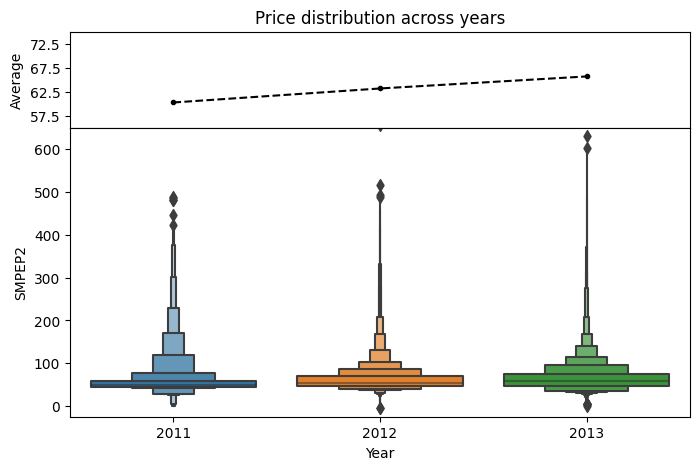

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,...,SystemLoadEP2,SMPEP2,monday,midweek,weekend,winter,summer,2011,2012,2013
0,2011-11-01,None,0,1,44,1,11,2011,0,315.31,...,3159.6,54.32,0,1,0,1,0,1,0,0


In [23]:
holiday_removed = 0
year_joined = 0
scaled = 0

mean_price = []
for year in [2011,2012,2013]:
    mean_price.append(df_elec['SMPEP2'][df_elec['Year'] == year].mean())

fig, axes = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig.subplots_adjust(hspace=0)
axes[0].plot(np.arange(0, 3), mean_price, 'k.--')
sns.boxenplot(data=df_elec, x='Year', y='SMPEP2', ax=axes[1])
axes[0].set(ylim=(55, 75), yticks=[57.5, 62.5, 67.5, 72.5], ylabel='Average')
axes[1].set(ylim=(-25, 650));
axes[0].set_title('Price distribution across years')
plt.show()




#One-hot encoding of the two categories of Year
year_one_hot = pd.get_dummies(df_elec['Year'])

if year_joined == 0:
    df_elec = df_elec.join(year_one_hot)
    year_joined += 1

df_elec.head(1)

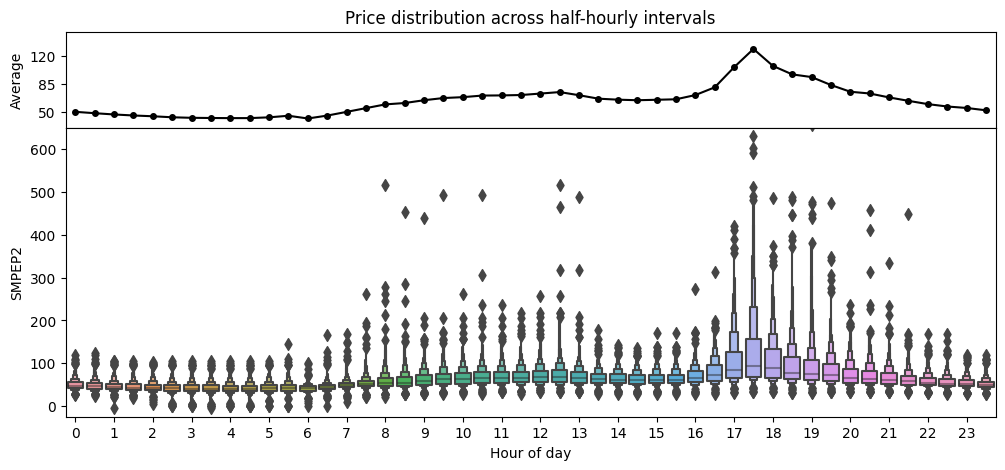

In [24]:
#Compute mean prices for periods of day
mean_price = []
for pday in list(range(0, 48)):
    mean_price.append(df_elec['SMPEP2'][df_elec['PeriodOfDay'] == pday].mean())

fig, axes = plt.subplots(2, 1, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig.subplots_adjust(hspace=0)
axes[0].plot(np.arange(0, 48), mean_price, 'k.-', markersize=8)
sns.boxenplot(data=df_elec, x='PeriodOfDay', y='SMPEP2', ax=axes[1])
axes[0].set(ylim=(30, 150), yticks=[50, 85, 120], ylabel='Average', title='Price distribution across half-hourly intervals')
axes[1].set(ylim=(-25, 650), xlabel='Hour of day');
axes[1].set(xticks=list(range(0, 48, 2)))
axes[1].set_xticklabels(list(range(0, 24)))
plt.show()

In [25]:
#Map the PeriodOfDay feature onto a sine and cosine function with a period of 24 hours
df_elec['day_sin'] = np.sin(df_elec['PeriodOfDay']*(2*np.pi/48))
df_elec['day_cos'] = np.cos(df_elec['PeriodOfDay']*(2*np.pi/48))

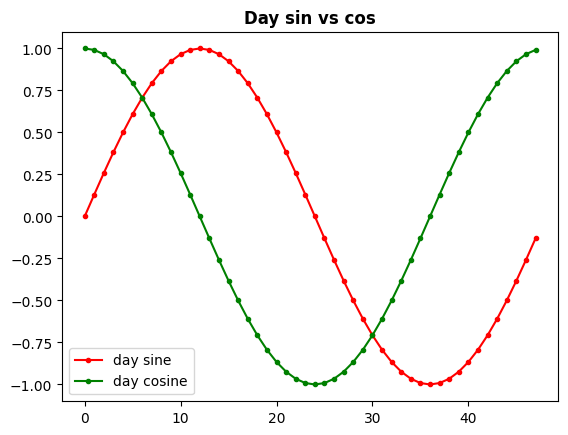

In [26]:
plt.plot(list(range(0, 48)), df_elec['day_sin'][0:48], 'r.-', label='day sine')
plt.plot(list(range(0, 48)), df_elec['day_cos'][0:48], 'g.-', label='day cosine')
#plt.set(yticks=[], xticks=[0, 12, 24, 36, 48], xlabel='Hour of day')
#plt.set_xticklabels([0, 6, 12, 18, 24]);
plt.title('Day sin vs cos', fontsize=12, weight='bold')
plt.legend()
plt.show()

# **Modelo Machine Learning**

In [27]:
df_elec.columns

Index([              'DateTime',                'Holiday',
                  'HolidayFlag',              'DayOfWeek',
                   'WeekOfYear',                    'Day',
                        'Month',                   'Year',
                  'PeriodOfDay', 'ForecastWindProduction',
                 'SystemLoadEA',                  'SMPEA',
               'ORKTemperature',           'ORKWindspeed',
                 'CO2Intensity',   'ActualWindProduction',
                'SystemLoadEP2',                 'SMPEP2',
                       'monday',                'midweek',
                      'weekend',                 'winter',
                       'summer',                     2011,
                           2012,                     2013,
                      'day_sin',                'day_cos'],
      dtype='object')

In [28]:
data_model = df_elec[[
    'DateTime',
    'SMPEP2',
    'ForecastWindProduction',
    'SystemLoadEA',
    'SMPEA',
    'ORKTemperature',
    'ORKWindspeed',
    'CO2Intensity',
    'ActualWindProduction',
    'SystemLoadEP2',
    'monday',
    'midweek',
    'weekend',
    'winter',
    'summer',
    2011,
    2012,
    2013,
    'day_sin',
    'day_cos'
        ]]

In [29]:
data_model.head()

,DateTime,SMPEP2,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,monday,midweek,weekend,winter,summer,2011,2012,2013,day_sin,day_cos
0,2011-11-01 00:00:00,54.32,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,0,1,0,1,0,1,0,0,0.000000,1.000000
1,2011-11-01 00:30:00,54.23,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,0,1,0,1,0,1,0,0,0.130526,0.991445
2,2011-11-01 01:00:00,54.23,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,0,1,0,1,0,1,0,0,0.258819,0.965926
3,2011-11-01 01:30:00,53.47,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,0,1,0,1,0,1,0,0,0.382683,0.923880
4,2011-11-01 02:00:00,39.87,342.90,2849.34,33.75,6.0,11.1,571.52,346.0,2655.64,0,1,0,1,0,1,0,0,0.500000,0.866025


In [30]:
# train_test_split

def train_test_val_split(dataframe, trainfrac=0.70, testfrac=0.20, valfrac=0.10):
  rows=len(dataframe)
  train=dataframe[0:int(rows*trainfrac)].copy().reset_index(drop=True)
  test=dataframe[int(rows*trainfrac):int(rows*(trainfrac+testfrac))].copy().reset_index(drop=True)
  val   = dataframe[int(rows*(trainfrac+testfrac)):int(rows*(trainfrac+testfrac+valfrac))].copy().reset_index(drop=True)

  return train,test,val

train, test, val = train_test_val_split(data_model)
train.head()

,DateTime,SMPEP2,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,monday,midweek,weekend,winter,summer,2011,2012,2013,day_sin,day_cos
0,2011-11-01 00:00:00,54.32,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,0,1,0,1,0,1,0,0,0.000000,1.000000
1,2011-11-01 00:30:00,54.23,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,0,1,0,1,0,1,0,0,0.130526,0.991445
2,2011-11-01 01:00:00,54.23,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,0,1,0,1,0,1,0,0,0.258819,0.965926
3,2011-11-01 01:30:00,53.47,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,0,1,0,1,0,1,0,0,0.382683,0.923880
4,2011-11-01 02:00:00,39.87,342.90,2849.34,33.75,6.0,11.1,571.52,346.0,2655.64,0,1,0,1,0,1,0,0,0.500000,0.866025


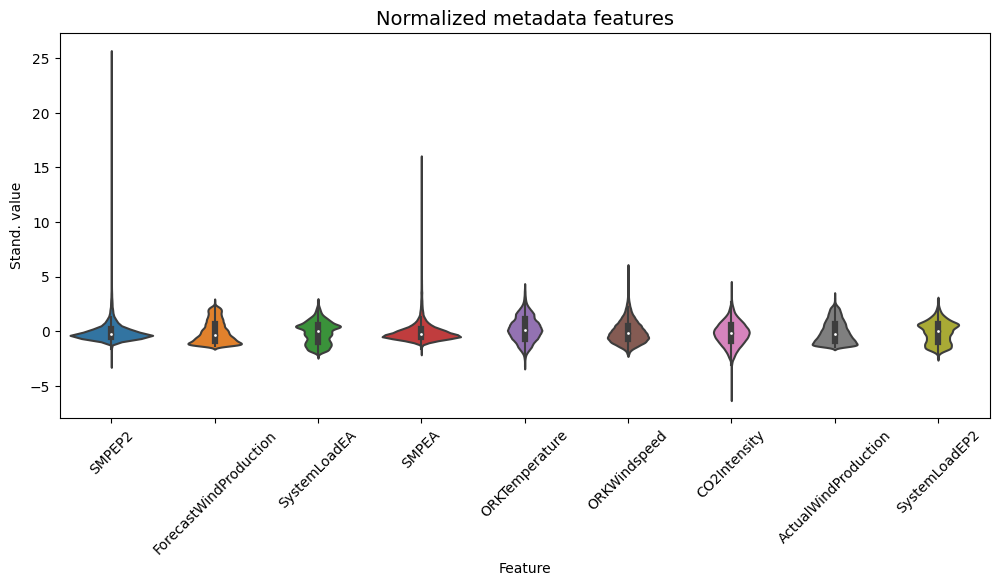

In [31]:
#Standardization of metadata features
if scaled == 0:
    train_mean = train[metadata_features].mean()
    train_std = train[metadata_features].std()

    train[metadata_features] = (train[metadata_features] - train_mean)/train_std
    test[metadata_features] = (test[metadata_features] - train_mean)/train_std
    val[metadata_features] = (val[metadata_features] - train_mean)/train_std

    data_scaled_feat = (data_model[metadata_features] - train_mean)/train_std
    data_scaled_feat = data_scaled_feat.melt(var_name='Feature', value_name='Stand. value')

    scaled += 1


fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.violinplot(x='Feature', y='Stand. value', data=data_scaled_feat, ax=ax)
ax.set_xticklabels(data_model[metadata_features].keys(), rotation=45)
ax.set_title('Normalized metadata features', fontsize=14)
plt.show()

In [32]:
#Class for generating batches of the time-resolved data set. Adjust input_width (# of rows in each batch),
# target_width (# of price predictions), and target_shift (# of rows between end of input and end of predictions)
class BatchGenerator():
    #Constructor
    def __init__(self, input_width=1, target_width=1, target_shift=1,
                 train_df=None, test_df=None, val_df=None,
                 target_feature=None):

        #Store data
        self.train_df = train_df
        self.test_df  = test_df
        self.val_df   = val_df

        #Feature parameters
        self.target_feature = target_feature
        self.feature_indices = {name: i for i, name in enumerate(self.train_df.columns)}
        self.target_feature_index = self.feature_indices[target_feature]

        #Batch parameters
        self.input_width = input_width
        self.target_width = target_width
        self.target_shift = target_shift

        self.total_batch_width = input_width + target_shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_batch_width)[self.input_slice]

        self.target_start = self.total_batch_width - self.target_width
        self.target_slice = slice(self.target_start, None)
        self.target_indices = np.arange(self.total_batch_width)[self.target_slice]


    #Method to split batches into inputs and targets
    def split_batches(self, tfdata):
        inputs = tfdata[:, self.input_slice, :]
        targets = tf.stack([tfdata[:, self.target_slice, self.target_feature_index]], axis=-1)

        #Slicing does not preserve shape information so set the shapes manually
        inputs.set_shape([None, self.input_width, None])
        targets.set_shape([None, self.target_width, None])

        return inputs, targets


    #Method to make batches from dataframe. Uses self.split_batches()
    def make_batches(self, df):
        data = np.array(df, dtype=np.float32)
        batches = tf.keras.utils.timeseries_dataset_from_array(
            data=df,
            targets=None,
            sequence_length=self.total_batch_width,
            sequence_stride=1,
            shuffle=False,
            batch_size=32
        )

        batches = batches.map(self.split_batches)
        return batches


    #Method to plot batches
    def plot(self, batch=None, plot_col=None, model=None, max_plots=3):

        self.batch = batch

        for inputs_, targets_ in self.batch:
            inputs = inputs_
            targets = targets_

        plot_col_index = self.feature_indices[plot_col]
        nplots = min(max_plots, len(inputs))

        fig, axes = plt.subplots(nplots, 1, figsize=(12, 6), sharex=True)
        fig.subplots_adjust(hspace=0)
        axes = axes.ravel()
        axes[-1].set(xlabel='Half-hours')

        samples = np.random.randint(0, len(targets), size=nplots)

        for n in range(nplots):
            axes[n].set(ylabel=plot_col, yticks=[]);
            axes[n].plot(self.input_indices, inputs[samples[n], :, plot_col_index],
                         marker='.', markersize=8, label='inputs')
            if plot_col == self.target_feature:
                axes[n].scatter(self.target_indices, targets[samples[n], :, :],
                                ec='k', label='targets', c='r', s=64)

            if model is not None:
                predictions = model(inputs)
                axes[n].scatter(self.target_indices, predictions[samples[n], :],
                            marker='X', ec='k', label='predictions', c='#ff7f0e', s=64)
            if n == 0:
                axes[n].legend()


    #Object properties to access and make batches of training, test or validation
    #uses self.make_batches()
    @property
    def train(self):
        return self.make_batches(self.train_df)

    @property
    def test(self):
        return self.make_batches(self.test_df)

    @property
    def val(self):
        return self.make_batches(self.val_df)

    #Represent method
    def __repr__(self):
        return '\n'.join([
            f'Total batch width  {self.total_batch_width}',
            f'Input indices      {self.input_indices}',
            f'Target indices     {self.target_indices}',
            f'Target feature     {self.target_feature}'])

In [33]:
#Initialize batches as objects of the BatchGenerator class
window24 = BatchGenerator(input_width=24, target_width=1, target_shift=1, target_feature='SMPEP2',
                           train_df=train.select_dtypes(exclude='datetime64[ns]'),
                           test_df=test.select_dtypes(exclude='datetime64[ns]'),
                           val_df=val.select_dtypes(exclude='datetime64[ns]')
                         )

window24

Total batch width  25
Input indices      [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Target indices     [24]
Target feature     SMPEP2

In [36]:
def compile_and_fit(model=None, data_batches=None, num_epochs=10, model_nm='my_model'):

    if model is not None:
        model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

    if data_batches is not None:
        history = model.fit(data_batches.train, epochs=num_epochs,
                          validation_data=data_batches.val)

    # SAVING MODEL DISABLED
    #if not os.path.exists(path+'\models/'):
    #    os.mkdir(path+'\models/')

    #model.save(path + '\models/' + model_nm)
    #print('Model saved in:', path + '\models/' + model_nm)

    return history

## **Build The RNN**

In [31]:
# Build RNN
datasetup=window24
model_name='4layers_100each_drop02_window24'
num_epochs=100
RNN=Sequential()




In [37]:

#Build Recurrent Neural Network (RNN)
datasetup = window24
model_name = '4layers_100each_drop02_window24'
num_epochs = 100

RNN = Sequential()

#1st layer
RNN.add(layers.LSTM(units=100, return_sequences=True,
                            input_shape=(datasetup.input_width, len(datasetup.feature_indices))))
RNN.add(layers.Dropout(0.2))

#2nd layer
RNN.add(layers.LSTM(units=100, return_sequences=True))
RNN.add(layers.Dropout(0.2))

#3rd layer
RNN.add(layers.LSTM(units=100, return_sequences=True))
RNN.add(layers.Dropout(0.2))

#4th layer
RNN.add(layers.LSTM(units=100, return_sequences=False))
RNN.add(layers.Dropout(0.2))

#output layer
RNN.add(layers.Dense(units=1))

In [38]:
#Compile, fit, and save a model with specified dataset
history = compile_and_fit(model=RNN,
                          data_batches=datasetup,
                          num_epochs=num_epochs,
                          model_nm=model_name)

Epoch 1/100
831/831 [==============================] - 107s 108ms/step - loss: 0.6770 - mean_absolute_error: 0.4278 - val_loss: 0.8785 - val_mean_absolute_error: 0.4569
Epoch 2/100
831/831 [==============================] - 89s 107ms/step - loss: 0.4857 - mean_absolute_error: 0.3103 - val_loss: 0.5143 - val_mean_absolute_error: 0.3230
Epoch 3/100
831/831 [==============================] - 88s 106ms/step - loss: 0.3963 - mean_absolute_error: 0.2594 - val_loss: 0.4577 - val_mean_absolute_error: 0.2842
Epoch 4/100
831/831 [==============================] - 87s 105ms/step - loss: 0.3862 - mean_absolute_error: 0.2481 - val_loss: 0.4628 - val_mean_absolute_error: 0.2781
Epoch 5/100
831/831 [==============================] - 88s 106ms/step - loss: 0.3782 - mean_absolute_error: 0.2410 - val_loss: 0.4428 - val_mean_absolute_error: 0.2747
Epoch 6/100
831/831 [==============================] - 86s 103ms/step - loss: 0.3653 - mean_absolute_error: 0.2337 - val_loss: 0.4361 - val_mean_absolute_error

In [39]:
model = RNN
performance_train = model.evaluate(datasetup.train)
performance_test  = model.evaluate(datasetup.test)
performance_val   = model.evaluate(datasetup.val)

119/119 [==============================] - 4s 31ms/step - loss: 0.3951 - mean_absolute_error: 0.2506


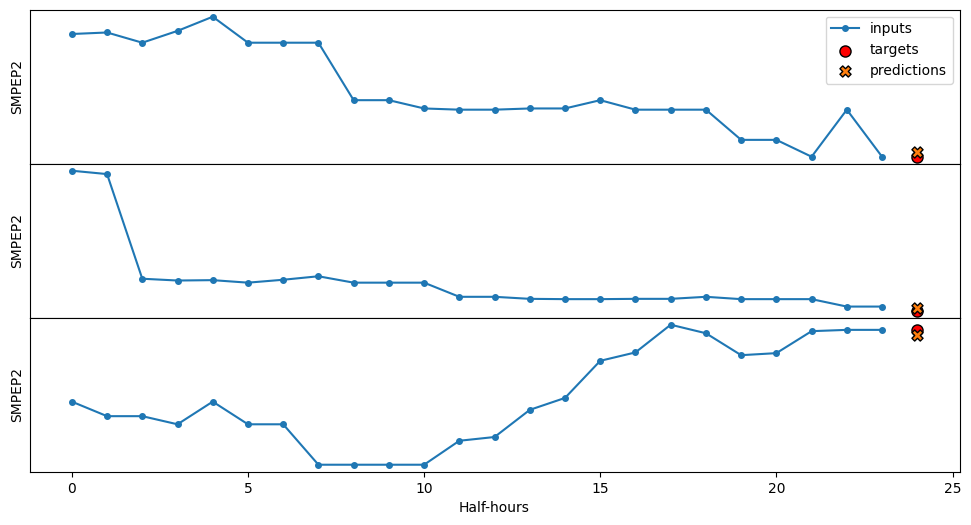

In [40]:
datasetup.plot(batch=datasetup.test.take(1), plot_col='SMPEP2', model=model)

237/237 [==============================] - 11s 34ms/step


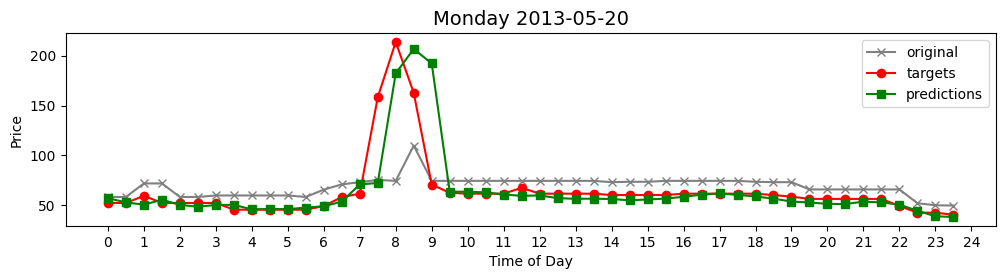

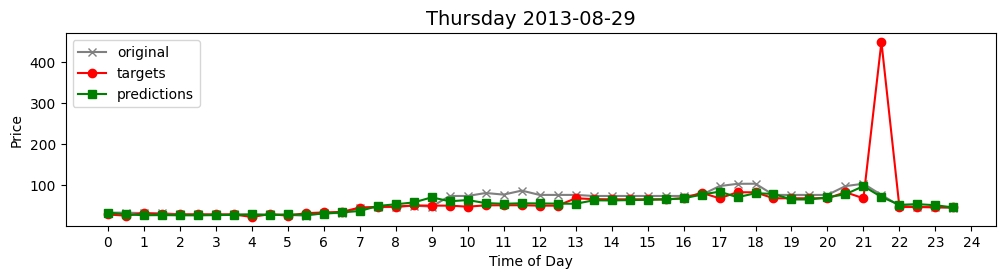

In [41]:
#Make new dataframe with orignal forecast, target prices, and model predictions for the test data set
predicts = model.predict(datasetup.test)

forecast_df = pd.DataFrame()
forecast_df.insert(loc=0, column='Date', value=test['DateTime'].apply(lambda x: x.date()))
forecast_df.insert(loc=1, column='Time', value=test['DateTime'].apply(lambda x: x.time()))

forecast_df.loc[:,'Original'] = test['SMPEA'].apply(lambda x: x*train_std['SMPEA'] + train_mean['SMPEA'])
forecast_df.loc[datasetup.input_width:,'Target'] = test['SMPEP2'].apply(lambda x: x*train_std['SMPEP2'] + train_mean['SMPEP2'])
forecast_df.loc[datasetup.input_width:,'Prediction'] = predicts*train_std['SMPEP2'] + train_mean['SMPEP2']

# Plot selected dates with original forecasts, target prices, and model predictions
dates = forecast_df['Date'].unique()[1::]
plot_dates = [dates[11], dates[112]]


x = list(range(0, 48))
for date in plot_dates:
    fig, ax = plt.subplots(1, 1, figsize=(12,2.5))
    ax.plot(x, forecast_df['Original'][forecast_df['Date'] == date], c='grey', marker='x', label='original')
    ax.plot(x, forecast_df['Target'][forecast_df['Date'] == date], c='r', marker='o', label='targets')
    ax.plot(x, forecast_df['Prediction'][forecast_df['Date'] == date], c='g', marker='s', label='predictions')
    ax.set(ylabel='Price', xlabel='Time of Day', xticks=list(range(0, 49, 2)))
    ax.set_xticklabels(list(range(0, 25)))
    ax.set_title(str(days_name[date.weekday()]) + ' ' + str(date), fontsize=14)
    ax.legend();

Original MAE          13.79 (21.50% of mean target price)
Model predictions MAE 6.22  (9.69% of mean target price)


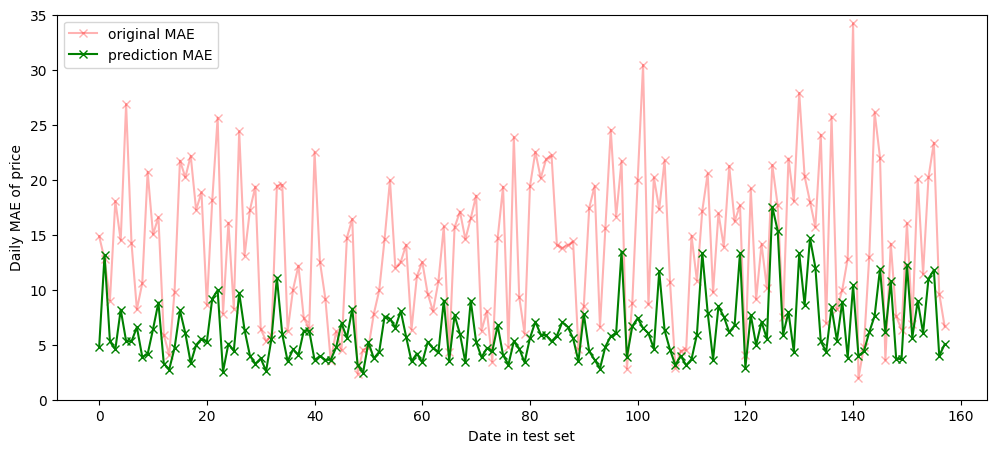

In [42]:
#Compute and plot the MAE for the original forecast and the model predictions
originalDailyMAE = []
predictionsDailyMAE = []
for date in dates:
    originals = np.array(forecast_df['Original'][forecast_df['Date'] == date])
    targets = np.array(forecast_df['Target'][forecast_df['Date'] == date])
    predictions = np.array(forecast_df['Prediction'][forecast_df['Date'] == date])

    originalDailyMAE.append(np.sum(np.abs(targets - originals))/len(targets))
    predictionsDailyMAE.append(np.sum(np.abs(targets - predictions))/len(targets))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(list(range(len(dates))), originalDailyMAE, c='r', alpha=0.3, marker='x', label='original MAE')
ax.plot(list(range(len(dates))), predictionsDailyMAE, c='g', marker='x', label='prediction MAE');

ax.set(ylabel='Daily MAE of price', xlabel='Date in test set');
ax.set(ylim = (0, 35))
ax.legend()

#Find the total MAE for all dates
originalMAE = np.sum(originalDailyMAE)/len(dates)
predictionsMAE = np.sum(predictionsDailyMAE)/len(dates)

print('Original MAE          {:.2f} ({:.2f}% of mean target price)'.format(originalMAE, originalMAE/mean_target_price*100))
print('Model predictions MAE {:.2f}  ({:.2f}% of mean target price)'.format(predictionsMAE, predictionsMAE/mean_target_price*100))